# Independent Study: Fruit and Vegetable Classification

##### In this lab, we will be training a `Convolutional Neural Network` (CNN) model to differentiate between various types of fruits and vegetables.

Defining the directories containing our images.

In [1]:
import os

# Directory with training apple pictures
train_apple_dir = os.path.join('/kaggle/input/yani-fruits-and-veggies-dataset/train/Apple')

# Directory with training melon pictures
train_melon_dir = os.path.join('/kaggle/input/yani-fruits-and-veggies-dataset/train/Melon')

# Directory with training pepper pictures
train_pepper_dir = os.path.join('/kaggle/input/yani-fruits-and-veggies-dataset/train/Pepper')

# Directory with training tomato pictures
train_tomato_dir = os.path.join('/kaggle/input/yani-fruits-and-veggies-dataset/train/Tomato')

# Directory with validation apple pictures
validation_apple_dir = os.path.join('/kaggle/input/yani-fruits-and-veggies-dataset/val/Apple')

# Directory with validation tomato pictures
validation_melon_dir = os.path.join('/kaggle/input/yani-fruits-and-veggies-dataset/val/Melon')

# Directory with validation pepper pictures
validation_pepper_dir = os.path.join('/kaggle/input/yani-fruits-and-veggies-dataset/val/Pepper')

# Directory with validation tomato pictures
validation_tomato_dir = os.path.join('/kaggle/input/yani-fruits-and-veggies-dataset/val/Tomato')



Now we'll see what the filenames look like in these directories:

In [2]:
train_apple_names = os.listdir(train_apple_dir)
train_melon_names = os.listdir(train_melon_dir)
train_pepper_names = os.listdir(train_pepper_dir)
train_tomato_names = os.listdir(train_tomato_dir)
validation_apple_names = os.listdir(validation_apple_dir)
validation_melon_names = os.listdir(validation_melon_dir)
validation_pepper_names = os.listdir(validation_pepper_dir)
validation_tomato_names = os.listdir(validation_tomato_dir)

print(f'EXAMPLE TRAIN SET: {train_apple_names[:2]}')
print(f'EXAMPLE VAL SET: {validation_tomato_names[:2]}')

EXAMPLE TRAIN SET: ['train-apple-144.jpg', 'train-apple-154.jpg']
EXAMPLE VAL SET: ['val-tomato-006.jpg', 'val-tomato-021.jpg']


We can find out the total number of images in the directories:

In [3]:
print(f'total training apple images: {len(os.listdir(train_apple_dir))}')
print(f'total training melon images: {len(os.listdir(train_melon_dir))}')
print(f'total training pepper images: {len(os.listdir(train_pepper_dir))}')
print(f'total training tomato images: {len(os.listdir(train_tomato_dir))}')
print(f'total validation apple images: {len(os.listdir(validation_apple_dir))}')
print(f'total validation melon images: {len(os.listdir(validation_melon_dir))}')
print(f'total validation pepper images: {len(os.listdir(validation_pepper_dir))}')
print(f'total validation tomato images: {len(os.listdir(validation_tomato_dir))}')

total training apple images: 77
total training melon images: 55
total training pepper images: 32
total training tomato images: 34
total validation apple images: 42
total validation melon images: 21
total validation pepper images: 15
total validation tomato images: 13


Now take a look at a few pictures to get a better sense of what they look like. First, configure the `matplotlib` parameters:

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 4 pictures of each class. We can rerun the cell to see a fresh batch each time:

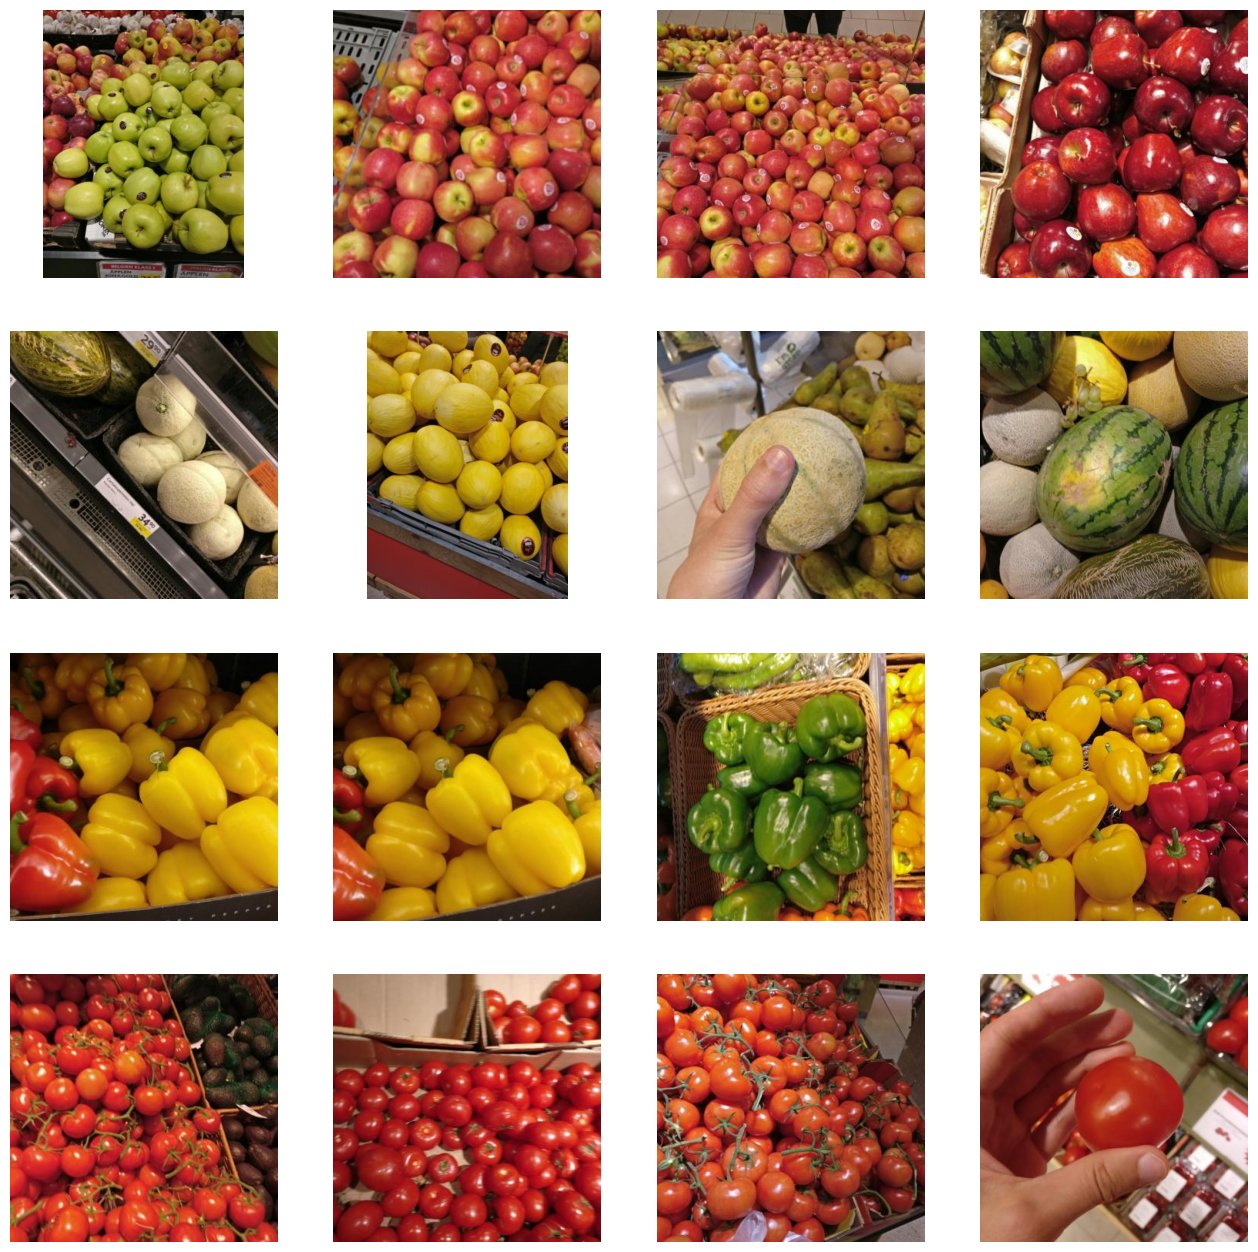

In [6]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 4
next_apple_pix = [os.path.join(train_apple_dir, fname) 
                for fname in train_apple_names[pic_index-4:pic_index]]
next_melon_pix = [os.path.join(train_melon_dir, fname) 
                for fname in train_melon_names[pic_index-4:pic_index]]
next_pepper_pix = [os.path.join(train_pepper_dir, fname) 
                for fname in train_pepper_names[pic_index-4:pic_index]]
next_tomato_pix = [os.path.join(train_tomato_dir, fname) 
                for fname in train_tomato_names[pic_index-4:pic_index]]

for i, img_path in enumerate(next_apple_pix+next_melon_pix+next_pepper_pix+next_tomato_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


### Data Preprocessing

Now We will setup the data generators:

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the training data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

# Define the validation data generator
val_datagen = ImageDataGenerator(rescale=1./255)

# Create the training data generator
train_generator = train_datagen.flow_from_directory(
        directory='/kaggle/input/yani-fruits-and-veggies-dataset/train',
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical')

# Create the validation data generator
val_generator = val_datagen.flow_from_directory(
        directory='/kaggle/input/yani-fruits-and-veggies-dataset/val',
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical')

2024-04-11 15:00:32.439983: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 15:00:32.440090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 15:00:32.596329: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 198 images belonging to 4 classes.
Found 91 images belonging to 4 classes.


## Building our model:

In [10]:
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add the additional layers
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training
Now we train the model for 20 epochs.

In [12]:
import tensorflow as tf
# Define early stopping and learning rate reduction callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.9058 - loss: 0.2426 - val_accuracy: 0.9451 - val_loss: 0.1817
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9312 - loss: 0.2532 - val_accuracy: 0.9451 - val_loss: 0.1797
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9161 - loss: 0.2794 - val_accuracy: 0.9451 - val_loss: 0.1740
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9138 - loss: 0.2713 - val_accuracy: 0.9451 - val_loss: 0.1695
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0

### Model Prediction

Now we will a look at actually running a prediction using the model. This code will allow us to choose 1 or more files from our file system, upload them, and run them through the model, giving an indication of whether the object is a apple or a tomato ..etc

In [16]:
import os
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Set the path to your image
image_path = '/kaggle/input/yani-fruits-and-veggies-dataset/train/Tomato/train-tomato-011.jpg'

# Load the image
img = load_img(image_path, target_size=(224, 224))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Make the prediction
pred = model.predict(x)
predicted_class = pred.argmax()

# Map the predicted class index to the class label
class_labels = ['Apple', 'Melon', 'Pepper', 'Tomato']
predicted_label = class_labels[predicted_class]

print(f"The predicted class is: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
The predicted class is: Tomato


### Visualizing Intermediate Representations

We can plot how the features are transformed as it goes through each layer.

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


/tmp/ipykernel_34/2366467963.py:51: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(6, 6, i+1)


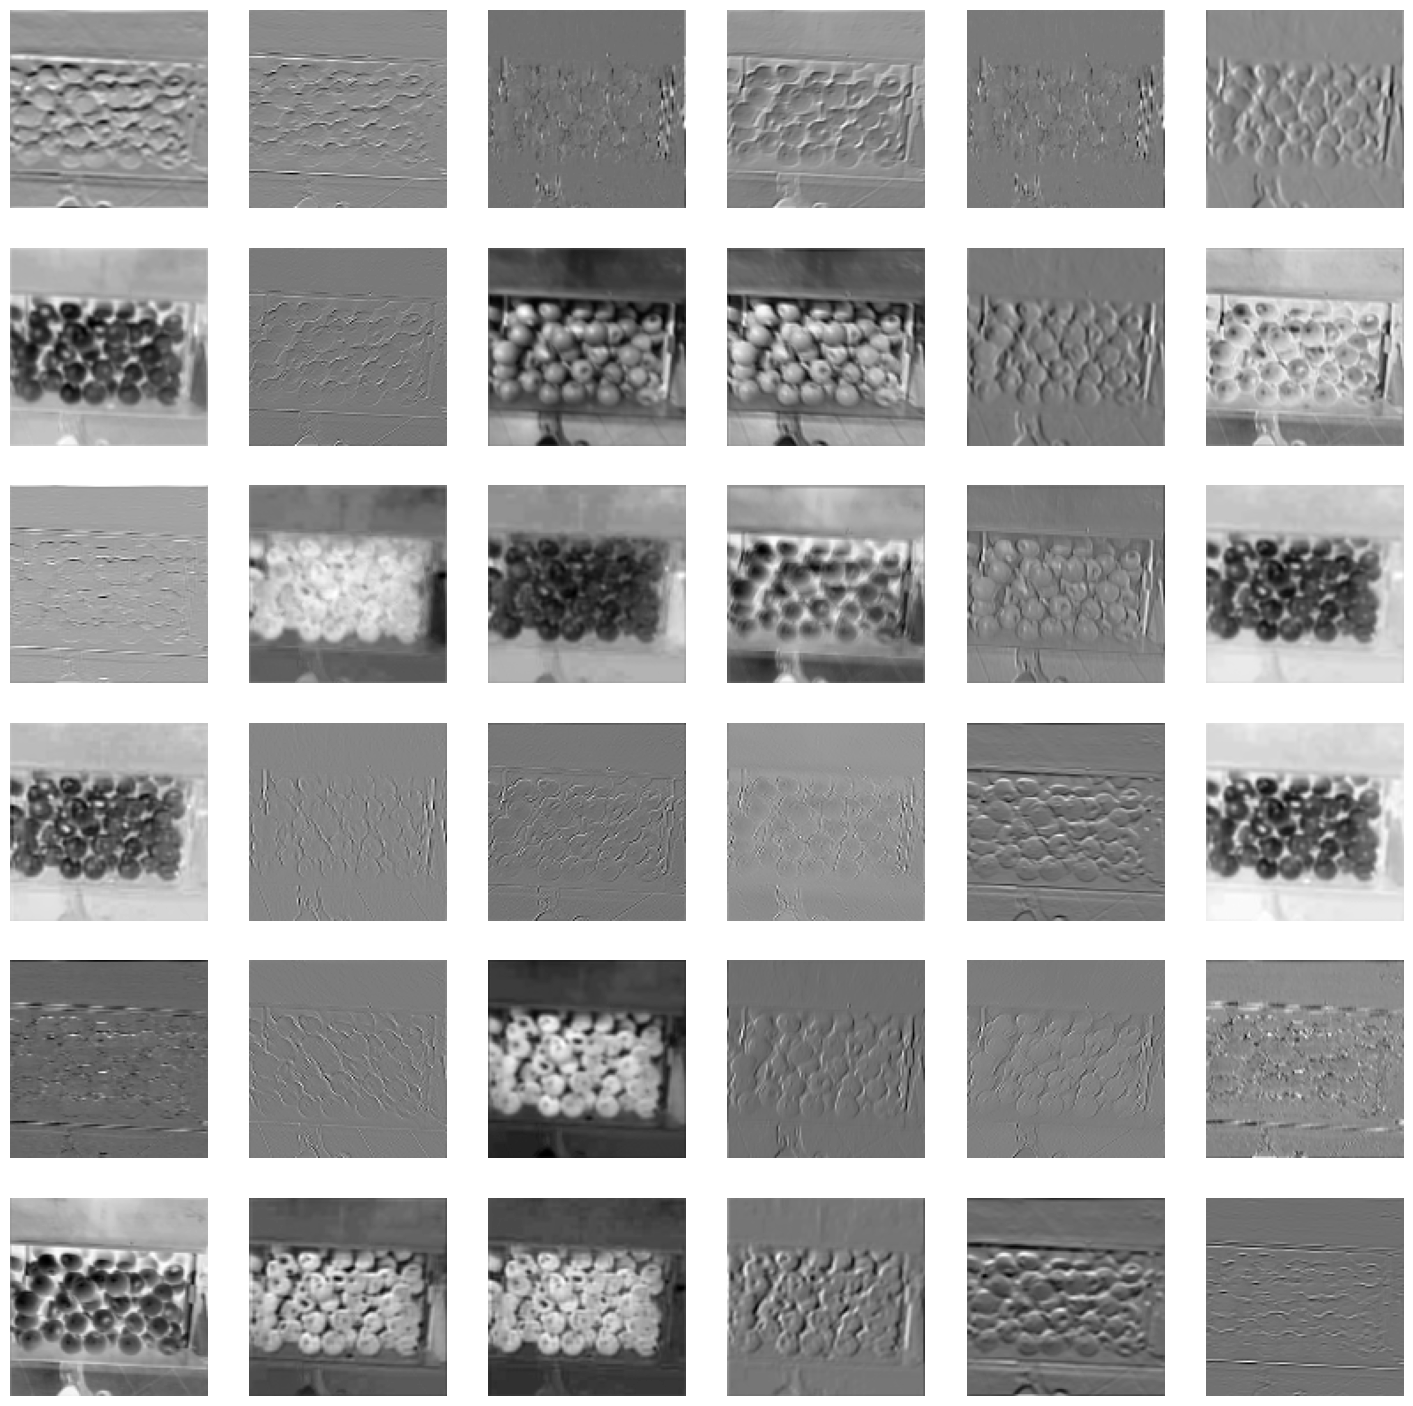

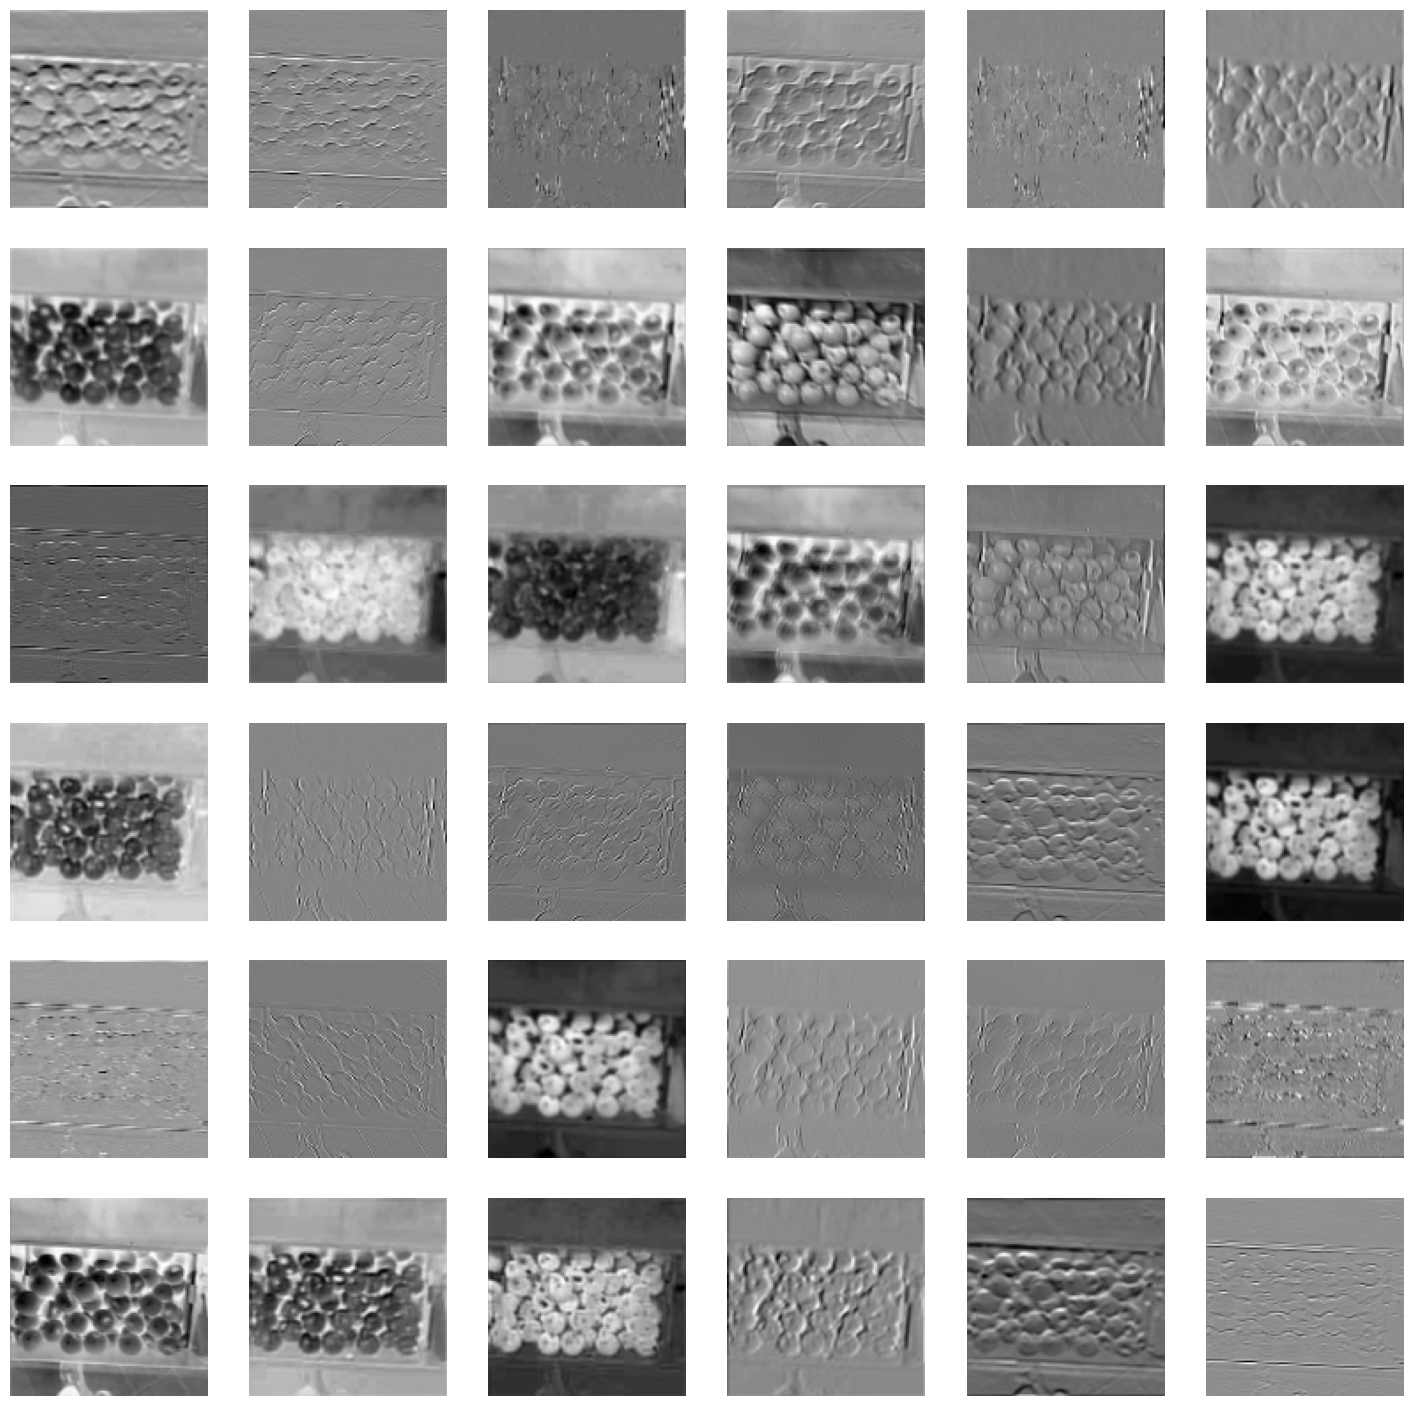

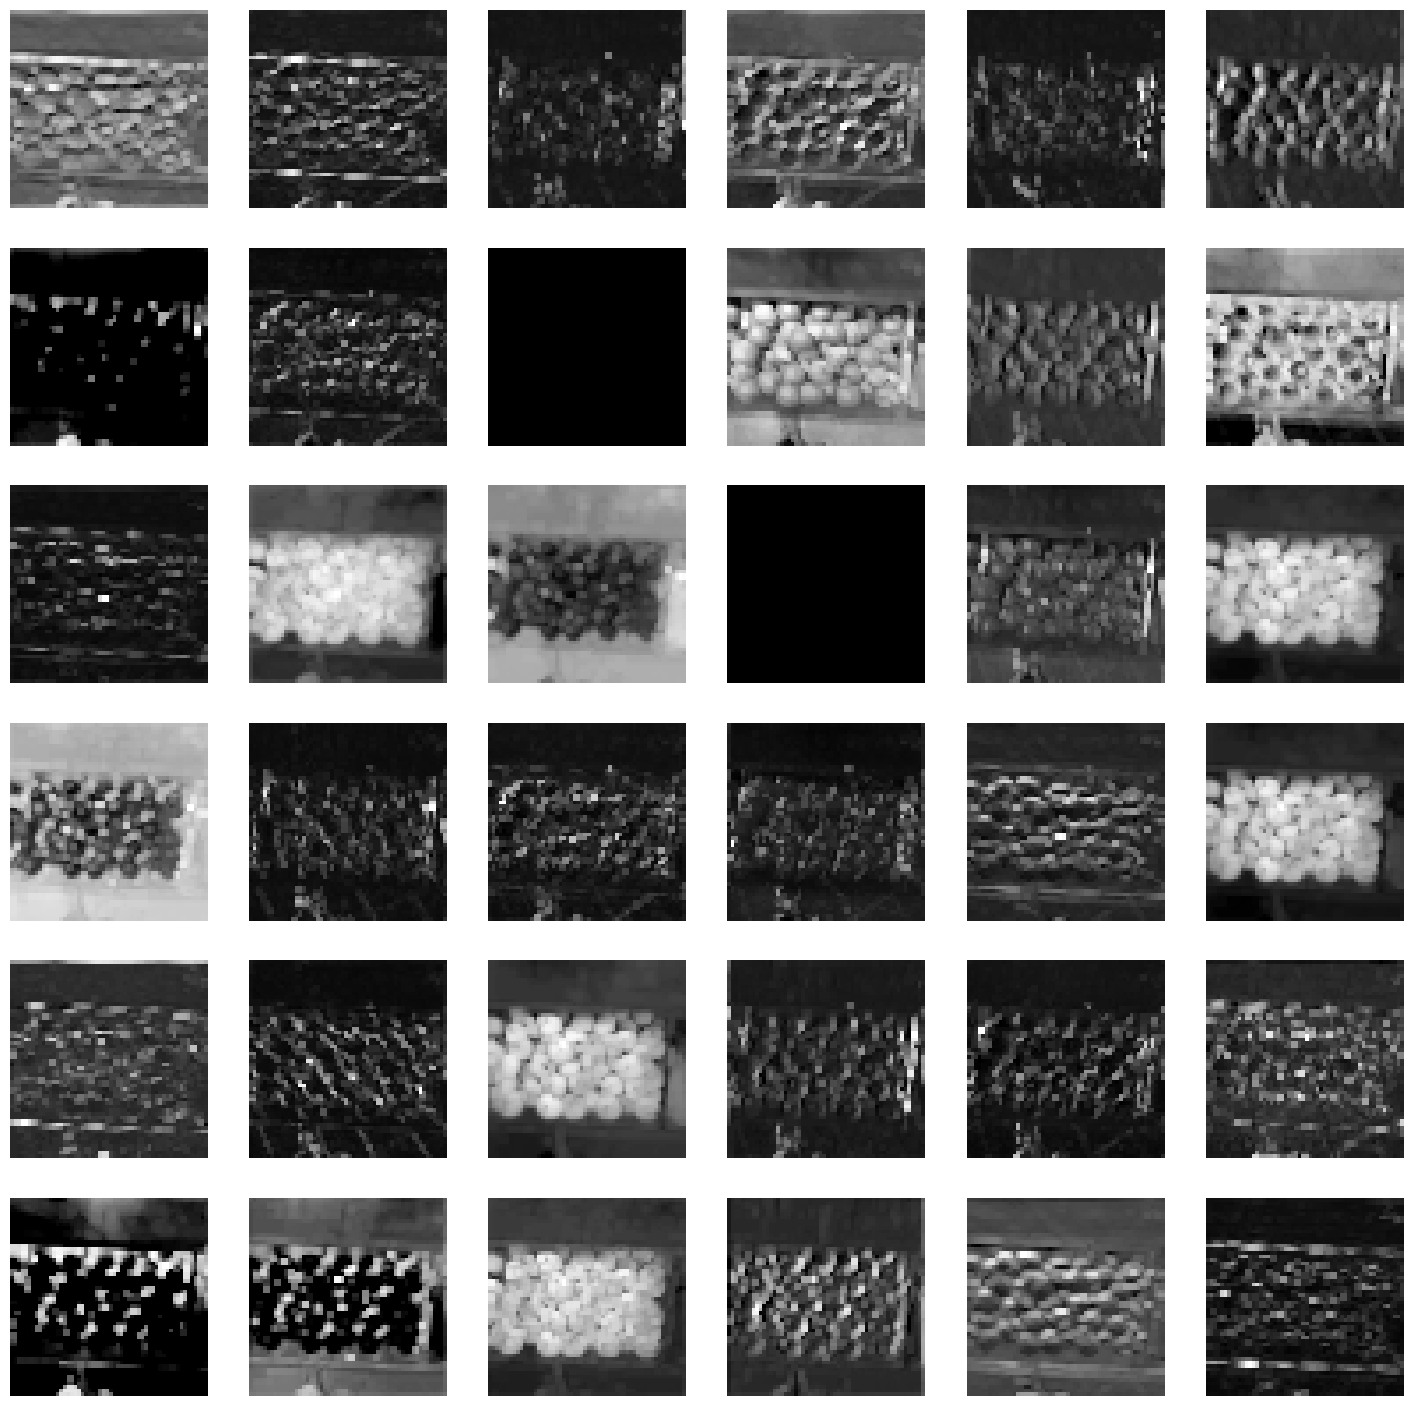

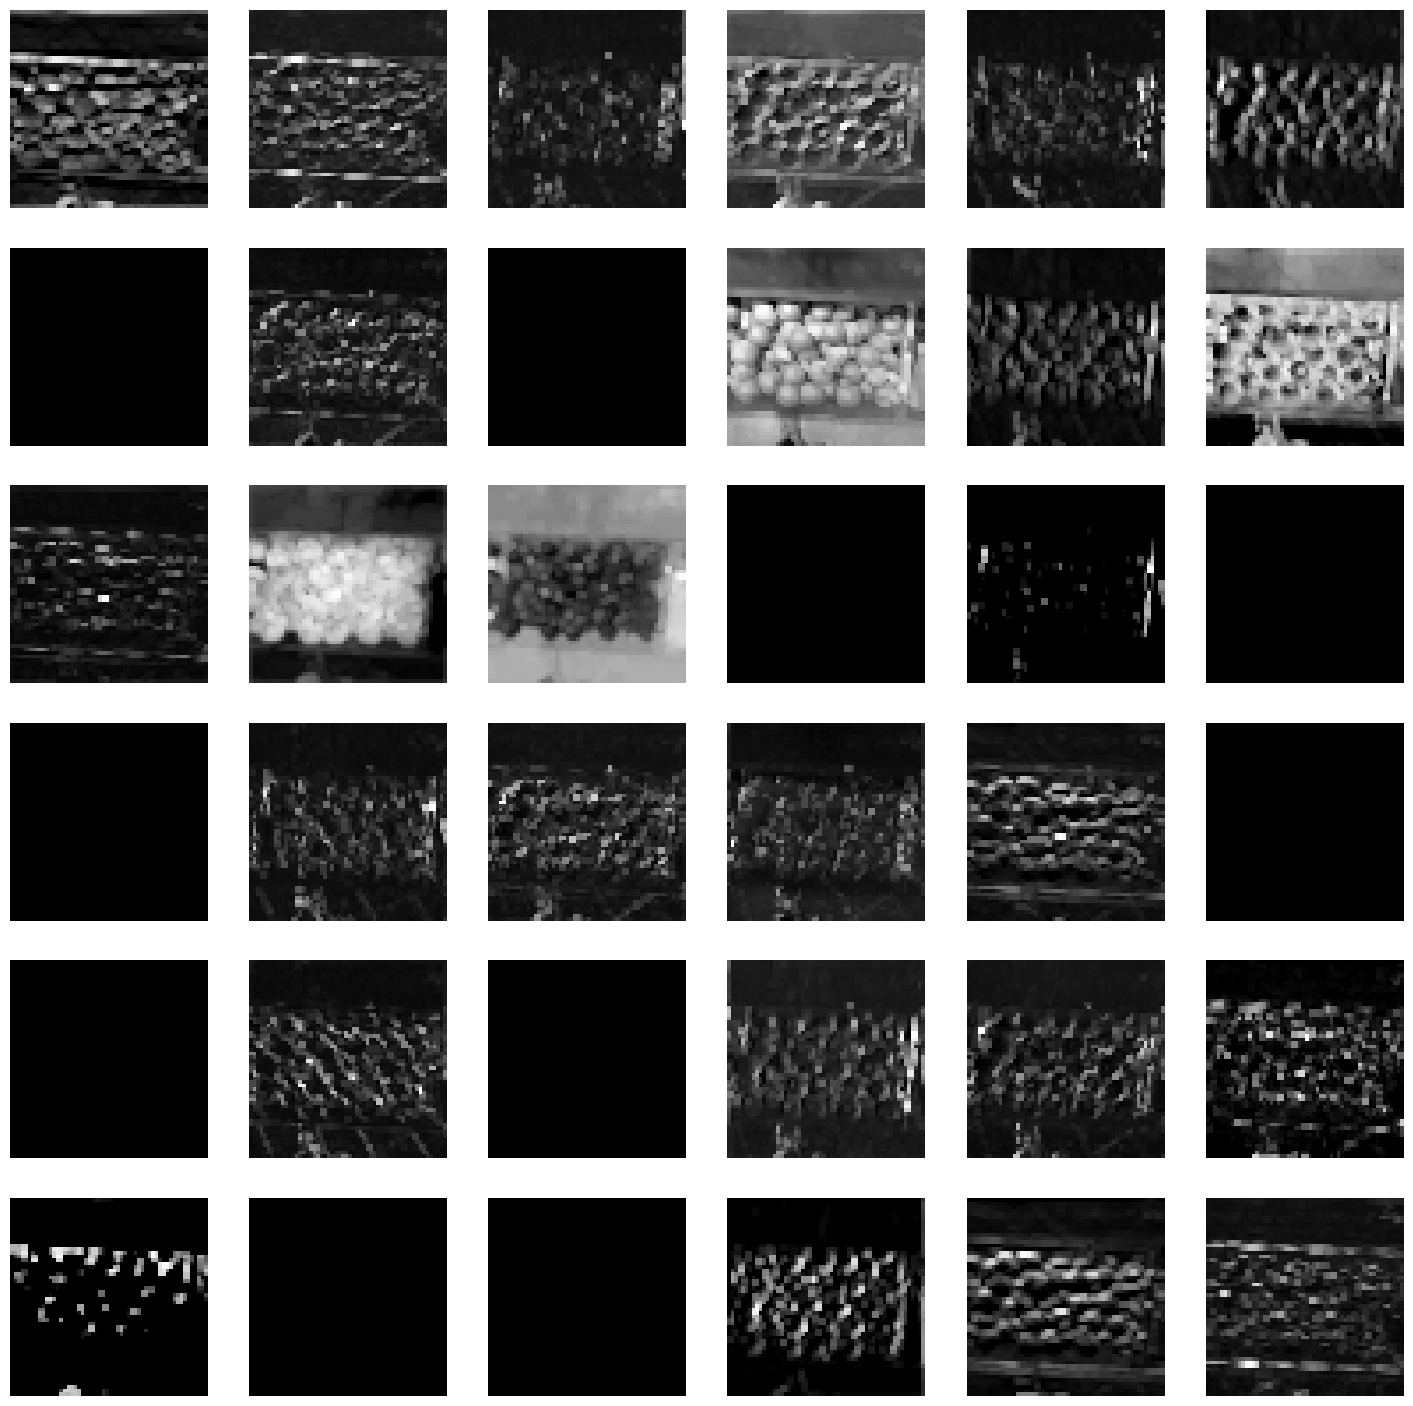

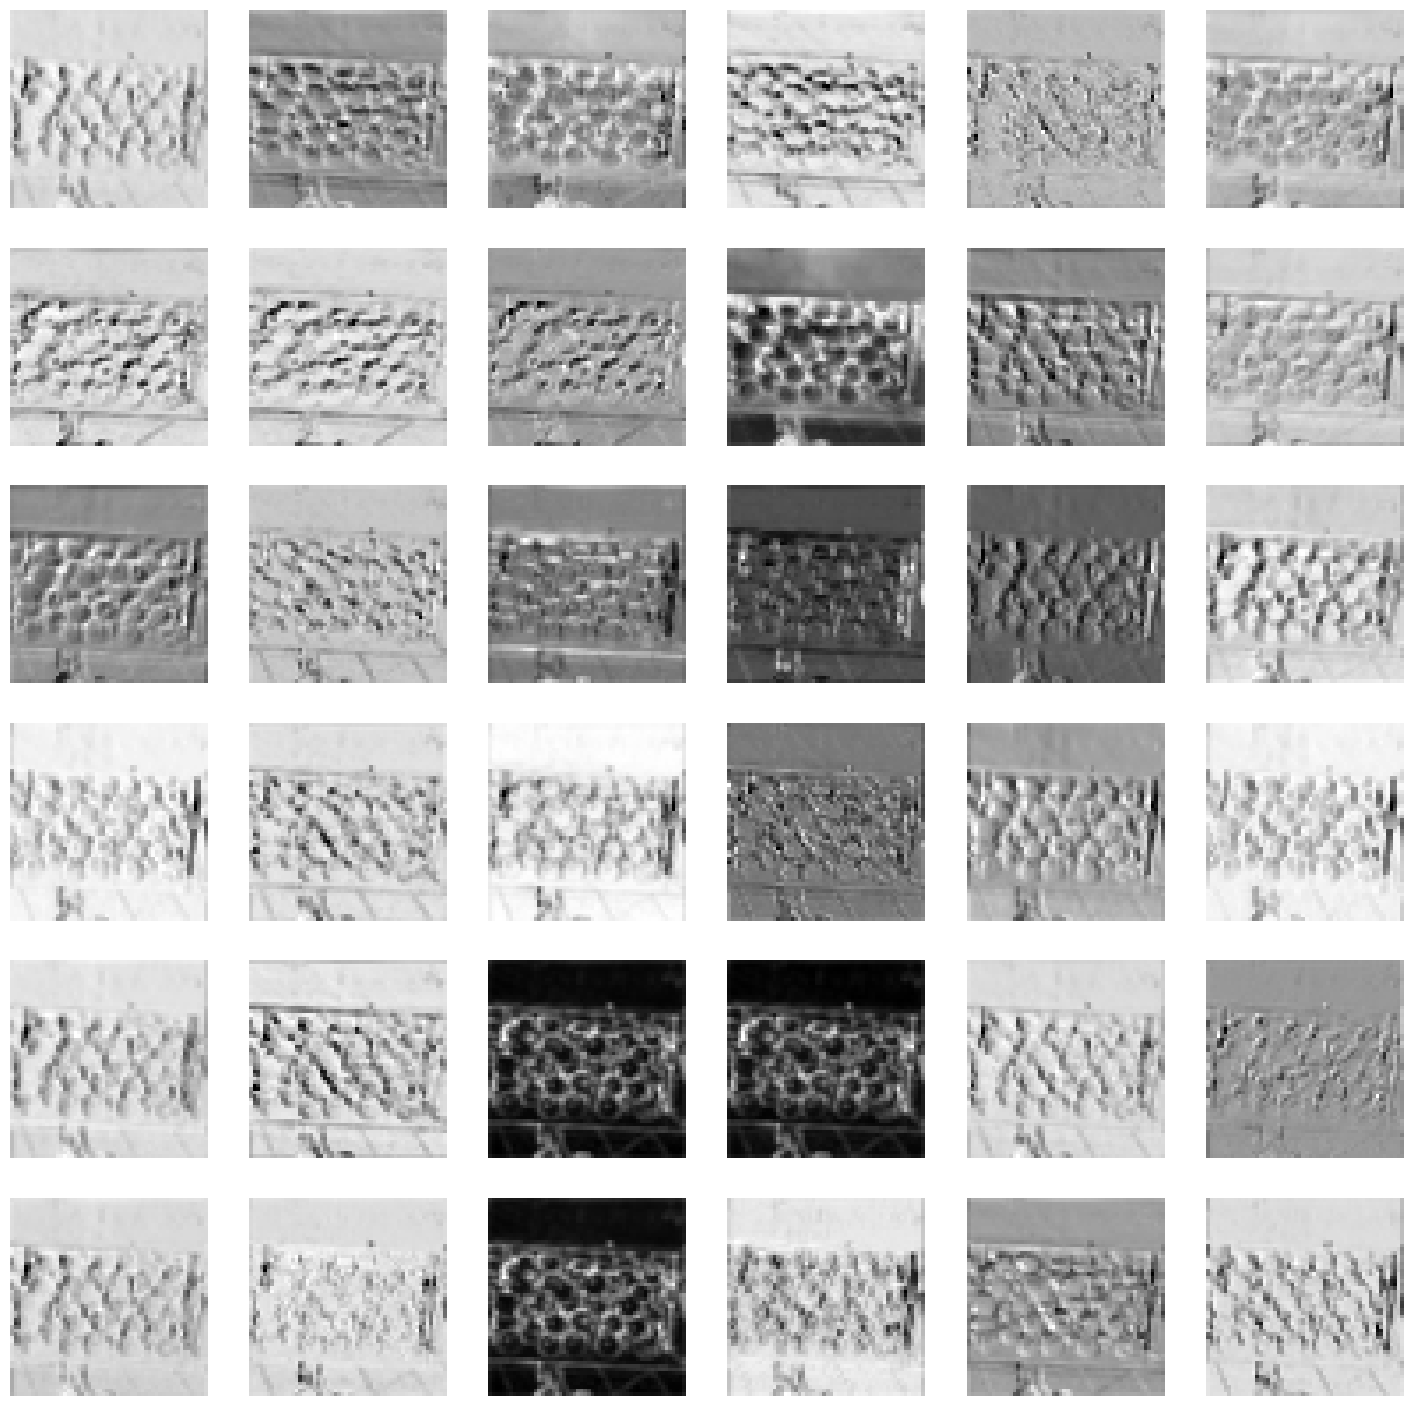

In [18]:
import os
import numpy as np
import keras
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Directory paths
train_apple_dir = '/kaggle/input/yani-fruits-and-veggies-dataset/train/Apple'
train_melon_dir = '/kaggle/input/yani-fruits-and-veggies-dataset/train/Melon'
train_pepper_dir = '/kaggle/input/yani-fruits-and-veggies-dataset/train/Pepper'
train_tomato_dir = '/kaggle/input/yani-fruits-and-veggies-dataset/train/Tomato'

# Choose a random directory
dirs = [train_apple_dir, train_melon_dir, train_pepper_dir, train_tomato_dir]
random_dir = np.random.choice(dirs)

# Choose a random image from the selected directory
image_files = [f.decode() for f in os.listdir(random_dir)]
random_image = np.random.choice(image_files)
image_path = os.path.join(random_dir, random_image)

# Load the image
img = load_img(image_path, target_size=(224, 224))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

# Define the model and get the intermediate layer outputs
from keras.applications.densenet import DenseNet121, preprocess_input
model = DenseNet121(weights='imagenet', include_top=False)

layer_outputs = [layer.output for layer in model.layers]
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

# Get the activations for the input image
activations = activation_model.predict(preprocess_input(x))

# Visualize the feature maps for the first 10 convolutional layers
layer_names = [layer.name for layer in model.layers]
num_layers_to_display = 10

for layer_idx, layer_name in enumerate(layer_names):
    if 'conv' in layer_name and layer_idx < num_layers_to_display:
        # Get the feature maps for the current layer
        feature_maps = activations[layer_idx][0]

        # Plot the feature maps
        plt.figure(figsize=(18, 18))
        plt.title(f'Feature Maps: {layer_name}')
        num_features = feature_maps.shape[-1]
        for i in range(min(36, num_features)):
            plt.subplot(6, 6, i+1)
            plt.imshow(feature_maps[:, :, i], cmap='gray')
            plt.axis('off')
        plt.show()

# Let's save our model

In [20]:
model.save("Nosh_Yani_CNN_V1.h5")